In [ ]:
%pip install --upgrade pip
%pip install pandas nltk matplotlib scikit-learn pyvi
%pip install gensim sentence-transformers
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 986.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=8341242ab97b6d66555f15acfa11f5be83237ca400bf19b898d05589cc733a92
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import torch
import tensorflow as tf

if torch.cuda.is_available():
    print("Torch - GPU is available.")
else:
    print("Torch - GPU is not available.")

if len(tf.config.list_physical_devices('GPU')) != 0:
    print("Tensorflow - GPU is available.")
else:
    print("Tensorflow - GPU is not available.")

Torch - GPU is available.
Tensorflow - GPU is available.


In [ ]:
env = "colab".lower() # local | colab
vec = "tf-idf".lower() # tf-idf | w2v | bert
architecture = "nb".lower() # svm | rf | nb
perform_grid_search = True # True | False

# w2v model download link: https://drive.google.com/uc?id=11MLjr3YZgzM7AVJOLokyybgdNvPFV3ba

if env == "local":
    data_path = "./data"
    vec_path = "./embeddings"
    result_path = "./results/"

    import gdown
    file_url = 'https://drive.google.com/uc?id=11MLjr3YZgzM7AVJOLokyybgdNvPFV3ba'
    if not os.path.exists(f"{vec_path}/vi-model-CBOW.bin"):
        os.makedirs('embeddings')
        gdown.download(file_url, f"{vec_path}/vi-model-CBOW.bin", quiet=False)
elif env == "colab":
    data_path = "/content/drive/MyDrive/Colab Notebooks/ML/data"
    vec_path = "/content/drive/MyDrive/Colab Notebooks/ML/embeddings"
    result_path = "/content/drive/MyDrive/Colab Notebooks/ML/results"

    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Loading & Preprocessing data

In [ ]:
import re
import pandas as pd
import numpy as np
from pyvi import ViTokenizer
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load train and test data from csv files
data_train = pd.read_csv(f"{data_path}/vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
train_labels = data_train.iloc[:, 0].values
train_texts = data_train.iloc[:, 1].values
print("Training data\n", data_train.head(5))

data_test = pd.read_csv(f"{data_path}/vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']
test_labels = data_test.iloc[:, 0].values
test_texts = data_test.iloc[:, 1].values
print("Testing data\n", data_test.head(5))

Training data
    Class                                               Data
0     -1  Mình đã dùng anywhere thế hệ đầu, quả là đầy t...
1     -1  Quan tâm nhất là độ trễ có cao không, dùng thi...
2     -1  dag xài con cùi bắp 98k....pin trâu, mỗi tội đ...
3     -1  logitech chắc hàng phải tiền triệu trở lên dùn...
4     -1  Đang xài con m175 cùi mía , nhà xài nhiều chuộ...
Testing data
    Class                                               Data
0     -1  Nói thiệt là mình thì thì chuột nào mình cũng ...
1     -1  Đang dùng mx1. Cũng ngon nhưng chưa đầy năm mà...
2     -1  Chưa thấy đc điểm thuyết phục để mua, nhất là ...
3     -1  Những phần xem báo tra cứu bản đồ, dịch vụ.. d...
4     -1  ĐÚNG LÀ MUA Ở VIỆT NAM KHÔNG ỨNG DỤNG ĐƯỢC GÌ ...


## 1.1. Encoding labels

In [ ]:
# -1 = Negative
#  0 = Neutral
#  1 = Positive
def encoding_labels(labels):
    encoded_labels = []
    for label in labels:
        if label == -1:
            encoded_labels += [-1]
        elif label == 0:
            encoded_labels += [0]
        else:
            encoded_labels += [1]
    return np.array(encoded_labels)

In [ ]:
encoded_labels_train = encoding_labels(train_labels)
for label in encoded_labels_train[:5]:
    print(f"- {label}")

- -1
- -1
- -1
- -1
- -1


## 1.2. Preprocessing texts

In [ ]:
# https://blog.luyencode.net/phan-loai-van-ban-tieng-viet/
# Cleaning text
def remove_html(text):
    pattern = r'<[^>]*>'
    non_html_text = re.sub(pattern, '', text)
    return non_html_text

def standardize_unicode(text):
    def load_standardized_unicode_dict():
        dic = {}
        char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
        charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
        for i in range(len(char1252)):
            dic[char1252[i]] = charutf8[i]
        return dic

    standardized_unicode_dict = load_standardized_unicode_dict()
    pattern = r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    standardize_unicode_text = re.sub(pattern, lambda x: standardized_unicode_dict[x.group()], text)
    return standardize_unicode_text

def normalize_tone(text):
    def load_normalized_tone_dict():
        dic = {}
        normalized = 'oà|Oà|OÀ|oá|Oá|OÁ|oả|Oả|OẢ|oã|Oã|OÃ|oạ|Oạ|OẠ|oè|Oè|OÈ|oé|Oé|OÉ|oẻ|Oẻ|OẺ|oẽ|Oẽ|OẼ|oẹ|Oẹ|OẸ|uỳ|Uỳ|UỲ|uý|Uý|UÝ|uỷ|Uỷ|UỶ|uỹ|Uỹ|UỸ|uỵ|Uỵ|UỴ'.split('|')
        non_normalized = 'òa|Òa|ÒA|óa|Óa|ÓA|ỏa|Ỏa|ỎA|õa|Õa|ÕA|ọa|Ọa|ỌA|òe|Òe|ÒE|óe|Óe|ÓE|ỏe|Ỏe|ỎE|õe|Õe|ÕE|ọe|Ọe|ỌE|ùy|Ùy|ÙY|úy|Úy|ÚY|ủy|Ủy|ỦY|ũy|Ũy|ŨY|ụy|Ụy|ỤY'.split('|')
        for i in range(len(non_normalized)):
            dic[non_normalized[i]] = normalized[i]
        return dic

    normalized_tone_dict = load_normalized_tone_dict()
    pattern = r'òa|Òa|ÒA|óa|Óa|ÓA|ỏa|Ỏa|ỎA|õa|Õa|ÕA|ọa|Ọa|ỌA|òe|Òe|ÒE|óe|Óe|ÓE|ỏe|Ỏe|ỎE|õe|Õe|ÕE|ọe|Ọe|ỌE|ùy|Ùy|ÙY|úy|Úy|ÚY|ủy|Ủy|ỦY|ũy|Ũy|ŨY|ụy|Ụy|ỤY'
    normalized_tone_text = re.sub(pattern, lambda x: normalized_tone_dict[x.group()], text)
    return normalized_tone_text

def tokenize_texts(text):
    tokenized_text = ViTokenizer.tokenize(text)
    return tokenized_text.split()

def remove_special_chars(text):
    # # Remove all special characters
    pattern = r'[^a-zA-Z0-9\w\sáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵđ_]'
    processed_text = re.sub(pattern, ' ', text)
    # Remove all numeric characters
    pattern = r'\d+'
    processed_text = re.sub(pattern, ' ', processed_text)
    # Remove 2 or more spaces
    pattern = r'\s+'
    processed_text = re.sub(pattern, ' ', processed_text)
    return processed_text

def cleaning_pipeline(texts):
    results = []
    for text in texts:
        text = text.lower()
        non_html_text  = remove_html(text)
        standardize_unicode_text = standardize_unicode(non_html_text)
        normalized_tone_text = normalize_tone(standardize_unicode_text)
        processed_text = remove_special_chars(normalized_tone_text)
        tokenized_text = tokenize_texts(processed_text)
        results += [tokenized_text]
    return results

In [ ]:
clean_texts_train = cleaning_pipeline(train_texts)
for text in clean_texts_train[:5]:
    print(f"- {text}")

- ['mình', 'đã', 'dùng', 'anywhere', 'thế_hệ', 'đầu', 'quả', 'là', 'đầy', 'thất_vọng', 'hiện_tại', 'đang', 'vứt', 'xó', 'giá', 'thì', 'đắt', 'ngốn', 'pin', 'như', 'ăn_gỏi', 'nặng']
- ['quan_tâm', 'nhất', 'là', 'độ', 'trễ', 'có', 'cao', 'không', 'dùng', 'thi_thoảng', 'nó', 'cứ', 'trễ', 'bực_mình', 'đấy', 'mới', 'chỉ', 'là', 'dùng', 'văn_phòng', 'chứ', 'game', 'thì', 'chắc', 'là', 'ném', 'đi', 'từ', 'lâu', 'không', 'biết', 'con', 'này', 'có', 'độ', 'trễ', 'không', 'nhỉ', 'dùng', 'nhiều', 'loại', 'nhưng', 'vẫn', 'kết', 'nhất', 'con', 'chuột', 'sứ', 'mitsumi', 'gọn', 'bấm', 'nảy', 'tốt']
- ['dag', 'xài', 'con', 'cùi', 'bắp', 'k', 'pin', 'trâu', 'mỗi', 'tội', 'đánh', 'liên_minh', 'ức_chế', 'đập', 'hết', 'con']
- ['logitech', 'chắc', 'hàng', 'phải', 'tiền', 'triệu', 'trở', 'lên', 'dùng', 'mới', 'thích', 'chứ', 'em', 'dùng', 'con', 'có', 'k', 'thấy', 'được', 'vài', 'bữa', 'là', 'hư', 'chuyển', 'sang', 'eblue', 'dùng', 'được', 'hơn', 'năm', 'chưa', 'thấy', 'hỏng']
- ['đang', 'xài', 'con', 'm',

In [ ]:
# # Import a Vietnamese stopwords list
# # https://github.com/stopwords-iso/stopwords-vi/blob/master/stopwords-vi.txt
# with open(f"{data_path}/stopwords_vi.txt", 'r', encoding='utf-8') as file:
#     stopwords_vi = sorted([line.strip() for line in file])
#     print(f"Vietnamese stopwords ({len(stopwords_vi)} elements):\n{stopwords_vi}\n")
#     # stopwords_vi = sorted(append_stopwords_list(cleaning_pipeline(train_texts) + cleaning_pipeline(test_texts), stopwords_vi))
#     # print(f"Appended Vietnamese stopwords ({len(stopwords_vi)} elements):\n{stopwords_vi}\n")

# clean_texts_train = remove_stopwords(clean_texts_train, stopwords_vi)
# for text in clean_texts_train[:5]:
#     print(f"- {text}")

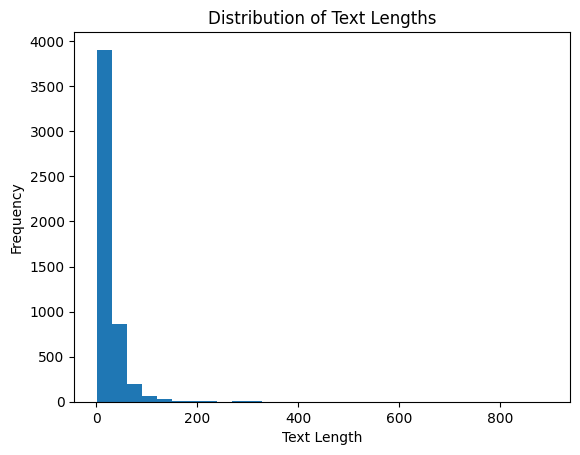

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'sequences' is the list of sequences obtained from tokenizing the text
text_lengths = [len(seq) for seq in clean_texts_train if len(seq) < 1000]

plt.hist(text_lengths, bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 2. Vectorizing the inputs

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def vectorize(vec, input_texts, vectorizer=None):
  if vec == "tf-idf":
    sentences = [" ".join(sentence) for sentence in input_texts]
    if vectorizer is None:
      vectorizer = TfidfVectorizer()
      embedding_matrix = vectorizer.fit_transform(sentences)
    else:
      embedding_matrix = vectorizer.transform(sentences)
  elif vec == "w2v":
    vec_model = KeyedVectors.load_word2vec_format(fname=f'{vec_path}/vi-model-CBOW.bin', binary=True)
    embedding_matrix = np.zeros((len(input_texts), 400))
    for i in range(len(input_texts)):
      embedding_vectors = []
      for word in input_texts[i]:
        try:
          embedding_vector = vec_model[word]
        except KeyError:
          embedding_vector = np.zeros(400)
        embedding_vectors += [embedding_vector]
      embedding_matrix[i] = np.mean(embedding_vectors, axis=0)
  elif vec == "bert":
      # https://huggingface.co/keepitreal/vietnamese-sbert
      vec_model = SentenceTransformer('keepitreal/vietnamese-sbert')
      sentences = [" ".join(sentence) for sentence in input_texts]
      embedding_matrix = vec_model.encode(sentences, device="cuda")
  return embedding_matrix, vectorizer

In [ ]:
X_input, vectorizer = vectorize(vec, clean_texts_train)
y_input = encoding_labels(train_labels)

print(f"Shape of an input embedding: {X_input[0].shape}")

Shape of an input embedding: (1, 7844)


# 3. Building the model

In [ ]:
import time
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

## 3.1. Support Vector Machine

In [ ]:
def svm_model(X, y, perform_grid_search):
  model = SVC()
  if perform_grid_search:
    # Define the parameter grid for grid search
    param_grid = {'C': [0.1, 1, 10, 100],
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    train_time0 = time.time()
    grid_search.fit(X, y)
    train_time1 = time.time() - train_time0
    print(f"Training time: {train_time1}")
    # Updated model with best parameters
    print(f"Best Parameters: {grid_search.best_params_}")
    model = grid_search.best_estimator_
  else:
    train_time0 = time.time()
    model.fit(X, y)
    train_time1 = time.time() - train_time0
    print(f"Training time: {train_time1}")
  return model

## 3.2. Random Forest

In [ ]:
def rf_model(X, y, perform_grid_search):
  model = RandomForestClassifier(random_state=42)
  if perform_grid_search:
    # Define the parameter grid for grid search
    param_grid = {'n_estimators': [50, 100, 150],
                  'max_depth': [None, 10, 20],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4]}
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    train_time0 = time.time()
    grid_search.fit(X, y)
    train_time1 = time.time() - train_time0
    print(f"Training time: {train_time1}")
    # Updated model with best parameters
    print(f"Best Parameters: {grid_search.best_params_}")
    model = grid_search.best_estimator_
  else:
    train_time0 = time.time()
    model.fit(X, y)
    train_time1 = time.time() - train_time0
    print(f"Training time: {train_time1}")
  return model

## 3.3. Naive Bayes

In [ ]:
def nb_model(X, y, perform_grid_search):
  model = MultinomialNB()
  if perform_grid_search:
    # Define the parameter grid for grid search
    param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    train_time0 = time.time()
    grid_search.fit(X, y)
    train_time1 = time.time() - train_time0
    print(f"Training time: {train_time1}")
    # Updated model with best parameters
    print(f"Best Parameters: {grid_search.best_params_}")
    model = grid_search.best_estimator_
  else:
    train_time0 = time.time()
    model.fit(X, y)
    train_time1 = time.time() - train_time0
    print(f"Training time: {train_time1}")
  return model

# 4. Training the model

In [ ]:
print(f"Architecture <{architecture}>_<{vec}> chosen")
if architecture == "svm":
  model = svm_model(X_input, y_input, perform_grid_search)
elif architecture == "rf":
  model = rf_model(X_input, y_input, perform_grid_search)
elif architecture == "nb":
  model = nb_model(X_input, y_input, perform_grid_search)

Architecture <nb>_<tf-idf> chosen
Training time: 0.07491326332092285
Best Parameters: {'alpha': 2.0}


In [ ]:
# with open(f'{result_path}/{architecture}_{vec}_checkpoint.pkl', 'wb') as file:
#     pickle.dump(model, file)
#     print(f"Model '{architecture}_{vec}' saved.")

# 5. Evaluating models

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# architecture = "svm"
# vec = "bert"
# with open(f'{result_path}/{architecture}_{vec}_checkpoint.pkl', 'rb') as file:
#     model = pickle.load(file)
#     print(f"Model '{architecture}_{vec}' loaded.")

In [ ]:
clean_texts_text = cleaning_pipeline(test_texts)
X_test, _ = vectorize(vec, clean_texts_text, vectorizer)
y_test = encoding_labels(test_labels)

test_time0 = time.time()
results = model.predict(X_test)
test_time1 = time.time() - test_time0
print(f"Testing time: {test_time1}")

# Print classification report
report = classification_report(y_test, results)
print(f"Classification Report:\n{report}")

Testing time: 1.0292079448699951
Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.68      0.68       350
           0       0.65      0.71      0.68       350
           1       0.76      0.71      0.74       350

    accuracy                           0.70      1050
   macro avg       0.70      0.70      0.70      1050
weighted avg       0.70      0.70      0.70      1050

